In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.cluster import KMeans

import tensorflow_datasets as tfds

from scipy.stats import mode
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import seaborn as sns; sns.set()  
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from skimage.color import rgb2gray

In [2]:
# Load in training data
ds = tfds.load('svhn_cropped', split='train', shuffle_files=False)
X = np.array([example["image"] for example in tfds.as_numpy(ds)])
y = np.array([example["label"] for example in tfds.as_numpy(ds)])

# Load in test data
ds_test = tfds.load('svhn_cropped', split='test', shuffle_files=False)
X_test = np.array([example["image"] for example in tfds.as_numpy(ds_test)])
y_test = np.array([example["label"] for example in tfds.as_numpy(ds_test)])

# Reformat data for ease of use later
X_flat = np.array(X)
X_flat = np.reshape(X_flat, (np.shape(X_flat)[0], -1))
X_test_flat = np.array(X_test)
X_test_flat = np.reshape(X_test_flat, (np.shape(X_test_flat)[0], -1))

acc =  0.22952519975414873


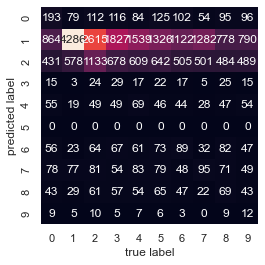

In [3]:

k_cluster = 100 #introducing k_clusters var - paper http://ufldl.stanford.edu/housenumbers/nips2011_housenumbers.pdf uses a special method of convolution K-means
# with 500 clusters.
# acc with 10 cluster = 19%
kmeans = KMeans(n_clusters=k_cluster, random_state=0).fit(X_flat)

clusters = kmeans.predict(X_test_flat)
labels = np.zeros_like(clusters)

for i in range(k_cluster):
    mask = (clusters == i)
    labels[mask] = mode(y_test[mask])[0]

print("acc = ", accuracy_score(y_test, labels))

mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');


In [4]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_flat, y)
print(lda.explained_variance_ratio_)

[0.1804435  0.14095242 0.13761753 0.1057773  0.0965962  0.09150843
 0.08572986 0.08263318 0.07874159]


In [4]:
#try  converting to b&w + pooling to reduce dimensionality
# https://www.geeksforgeeks.org/cnn-introduction-to-pooling-layer/

X_gray = rgb2gray(X)
num1, l, w = np.shape(X_gray)
X_gray = np.reshape(X_gray, (num1, l, w, 1))

X_test_gray = rgb2gray(X_test)
num2, l, w = np.shape(X_test_gray)
X_test_gray = np.reshape(X_test_gray, (num2, l, w, 1))

pool = tf.keras.layers.AveragePooling2D(pool_size=(8, 8), strides=None, padding="valid")


X_g_pool = pool(X_gray)
X_t_g_pool = pool(X_test_gray)

X_g_p_f = np.reshape(X_g_pool, (num1, -1))
X_t_g_p_f = np.reshape(X_t_g_pool, (num2, -1))


acc =  0.28196066379840196


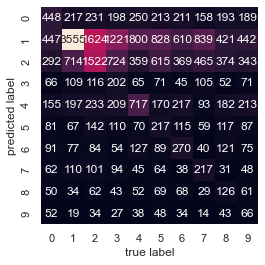

In [25]:
k_cluster = 500 #introducing k_clusters var - paper http://ufldl.stanford.edu/housenumbers/nips2011_housenumbers.pdf uses a special method of convolution K-means
# with 500 clusters.
# acc with 10 cluster = 19%
# acc with 8x8 window, 100 clusters = 23%
# acc with 8x8 window, 500 clusters = 28%
kmeans = KMeans(n_clusters=k_cluster, random_state=0).fit(X_g_p_f)

clusters = kmeans.predict(X_t_g_p_f)
labels = np.zeros_like(clusters)

for i in range(k_cluster):
    mask = (clusters == i)
    labels[mask] = mode(y_test[mask])[0]

print("acc = ", accuracy_score(y_test, labels))

mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [5]:
#might be good to get make the data zero mean and unit variance
#use gaussian mixtures? https://datascience.stackexchange.com/questions/24324/how-to-use-k-means-outputs-extracted-features-as-svm-inputs 

###################### this is the start of the more complicated feature extraction: Mapping windows of data to features found from Guassian mixture

mean = np.mean(X_gray, axis = 0)
std = np.std(X_gray, axis = 0)
X_adj = (X_gray - mean)/std
X_test_adj = (X_test_gray - mean)/std


In [6]:
from sklearn.feature_extraction import image
from sklearn.mixture import GaussianMixture
from sklearn.svm import SVC

In [7]:
#create a random dataset of 8x8 images to build fk(x)

patches = image.extract_patches_2d(X_adj, (8, 8), max_patches = .09)

In [9]:
patches = np.reshape(patches, (np.shape(patches)[0], -1))
gm = GaussianMixture(n_components=150).fit(patches)

In [ ]:
#now that we have 500 different features we map the original images to this new space

X_transform = np.zeros((np.shape(X_adj)[0], 4, 4))

for i in range(np.shape(X_adj)[0]):
    for w in range(4):
       for w2 in range(4):
           x_ij = X_adj[i, w*8: w*8+7, w*8: w*8+7]
           x_ij = np.reshape(x_ij, (1, -1))
           y_ij = gm.predict(x_ij)
           X_transform[i, w, w2] = y_ij


X_test_transform = np.zeros((np.shape(X_test_adj)[0], 4, 4))

for i in range(np.shape(X_test_adj)[0]):
    for w in range(4):
       for w2 in range(4):
           x_ij = X_test_adj[i, w*8: w*8+7, w*8: w*8+7]
           x_ij = np.reshape(x_ij, (1, -1))
           y_ij = gm.predict(x_ij)
           X_test_transform[i, w, w2] = y_ij



In [ ]:
pool = tf.keras.layers.AveragePooling2d(pool_size=(2, 2), strides=None, padding="valid")
phi = pool(X_transform)
phi_test = pool(X_test_transform)

phi_flat = np.reshape(phi, (np.shape(phi)[0], -1))
phi_test_flat = np.reshape(phi, (np.shape(phi_test)[0], -1))

In [ ]:
svm = SVM()
svm.fit(phi_flat, y)
acc = svm.score(phi_test_flat, y_test)